In [27]:
from pathlib import Path
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader,Dataset,Subset
from torchvision import transforms
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
DATA_ROOT = Path("/content/drive/MyDrive")
TRAIN_PATH = DATA_ROOT/"train"
APPLES_TRAIN_PATH = TRAIN_PATH/"apples"
TOMATOES_TRAIN_PATH = TRAIN_PATH/"tomatoes"
TEST_PATH = DATA_ROOT/"test"
APPLES_TEST_PATH = TEST_PATH/"apples"
TOMATOES_TEST_PATH = TEST_PATH/"tomatoes"

In [29]:
apples_images=list(APPLES_TRAIN_PATH.rglob("*.jpeg"))
print(f"The number of training apples are:{len(apples_images)}")

The number of training apples are:164


In [30]:
tomatoes_images=list(TOMATOES_TRAIN_PATH.rglob("*.jpeg"))
print(f"The number of training tomatoes are:{len(tomatoes_images)}")

The number of training tomatoes are:130


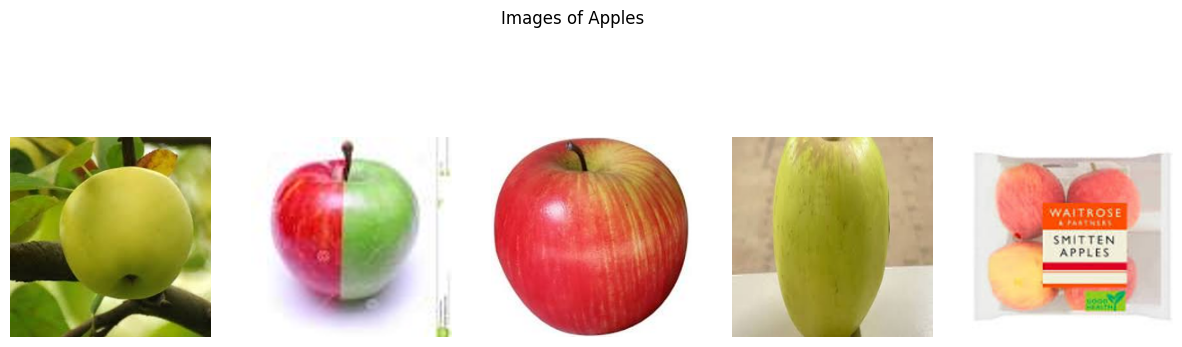

In [31]:
fig,axes=plt.subplots(1,5,figsize=(15,5))
for i in range(5):
  image=random.choice(apples_images)
  image=Image.open(image).resize((224,224))
  axes[i].imshow(image)
  axes[i].axis('off')
fig.suptitle("Images of Apples", x=0.5, y=0.95)
plt.show()

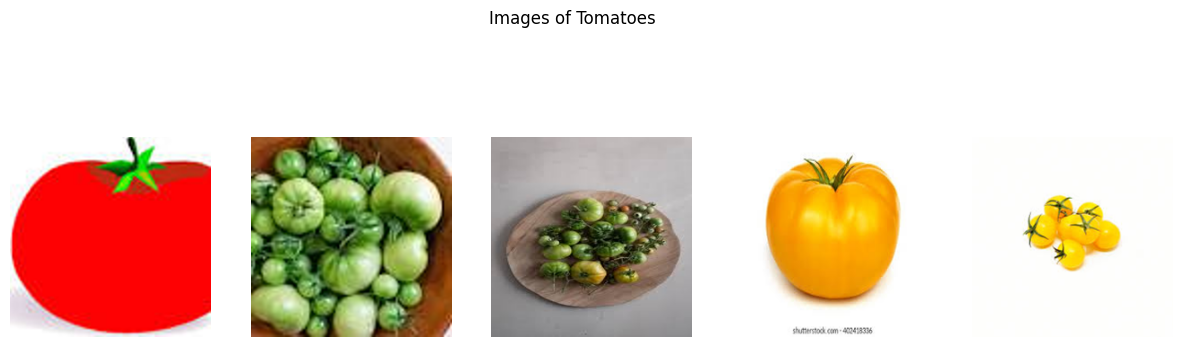

In [32]:
fig,axes=plt.subplots(1,5,figsize=(15,5))
for i in range(5):
  image=random.choice(tomatoes_images)
  image=Image.open(image).resize((224,224))
  axes[i].imshow(image)
  axes[i].axis('off')
fig.suptitle("Images of Tomatoes", x=0.5, y=0.95)
plt.show()

In [33]:
class CustomDataset(Dataset):

  def __init__(self,root_path,transforamtion=None):
    super().__init__()
    self.root_path=root_path
    self.transforamtion=transforamtion
    self.img_paths=[]
    self.labels=[]

    classes=["apples","tomatoes"]

    for index,class_name in enumerate(classes):
      class_folder=self.root_path/class_name
      for img in class_folder.iterdir():
        if img.is_file() and img.suffix.lower() in [".jpeg",".jpg",".png"]:
          self.img_paths.append(img)
          self.labels.append(index)

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, index):
    img=self.img_paths[index]
    label=self.labels[index]

    img=Image.open(img).convert("RGB").resize((224,224))

    if self.transforamtion:
      img=self.transforamtion(img)

    return img,label

In [34]:
class Model(nn.Module):

  def __init__(self,num_features,num_classes=2):
    super().__init__()
    self.classifier=nn.Flatten()
    self.linear=nn.Linear(num_features,num_classes)

  def forward(self,x):
    out=self.classifier(x)
    out=self.linear(out)
    return out

In [35]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])


In [36]:
dataset=CustomDataset(
    TRAIN_PATH,
    transforamtion=transform
)
print(len(dataset))

294


In [37]:
train_idx,val_idx=train_test_split(range(len(dataset)),test_size=0.2,random_state=True,stratify=dataset.labels)

In [38]:
train_data=Subset(dataset,train_idx)
val_data=Subset(dataset,val_idx)

In [39]:
train_dataloader=DataLoader(train_data,batch_size=8,shuffle=True)
val_dataloader=DataLoader(val_data,batch_size=8,shuffle=False)

In [40]:
model=Model(224*224*3)
loss=nn.CrossEntropyLoss()
learning_rate=1e-4
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
epochs=10

In [41]:
train_loss=[]
train_accuracy=[]
for epoch in range(epochs):
  epoch_loss=0
  total=0
  correct=0
  for batch_feature,batch_label in train_dataloader:
    optimizer.zero_grad()
    # Send the input to the model:
    output=model(batch_feature)
    # Calculate the accuracy:
    _,predicted=torch.max(output,1)
    total=total+batch_feature.shape[0]
    correct=correct+(predicted==batch_label).sum().item()
    # Calculate the loss
    loss_value=loss(output,batch_label)
    # Update the gradients
    loss_value.backward()
    optimizer.step()
    epoch_loss += loss_value.item()
  avg_epoch_loss=epoch_loss/len(train_dataloader)
  accuracy=correct/total
  train_accuracy.append(accuracy)
  train_loss.append(avg_epoch_loss)

  print(f"Epoch:{epoch+1}, Loss:{avg_epoch_loss:.4f}, Accuracy:{accuracy:.4f}")

Epoch:1, Loss:2.4902, Accuracy:0.5574
Epoch:2, Loss:1.1659, Accuracy:0.7191
Epoch:3, Loss:0.5558, Accuracy:0.7915
Epoch:4, Loss:0.6765, Accuracy:0.8000
Epoch:5, Loss:0.2748, Accuracy:0.9064
Epoch:6, Loss:0.2222, Accuracy:0.9149
Epoch:7, Loss:0.1147, Accuracy:0.9532
Epoch:8, Loss:0.1426, Accuracy:0.9532
Epoch:9, Loss:0.1934, Accuracy:0.9362
Epoch:10, Loss:0.1708, Accuracy:0.9319


In [42]:
# Evaluation:
model.eval()

eval_loss=[]
eval_accuracy=[]
for epoch in range(epochs):
  epoch_loss=0
  total=0
  correct=0
  for batch_feature,batch_label in val_dataloader:
    optimizer.zero_grad()
    output=model(batch_feature)

    _,predicted=torch.max(output,1)
    total=total+batch_feature.shape[0]
    correct=correct+(predicted==batch_label).sum().item()

    val_loss=loss(output,batch_label)
    val_loss.backward()
    optimizer.step()

    epoch_loss=epoch_loss+val_loss.item()

  average_epoch_loss=epoch_loss/len(val_dataloader)
  accuracy=correct/total

  eval_loss.append(avg_epoch_loss)
  eval_accuracy.append(accuracy)

  print(f"Epoch {epoch+1}, Loss:{average_epoch_loss}, Accuracy:{accuracy}")

Epoch 1, Loss:1.8639604821801186, Accuracy:0.6440677966101694
Epoch 2, Loss:1.1143662221729755, Accuracy:0.6779661016949152
Epoch 3, Loss:0.6996806376264431, Accuracy:0.7796610169491526
Epoch 4, Loss:0.25212238021140365, Accuracy:0.8813559322033898
Epoch 5, Loss:0.10314435119653353, Accuracy:0.9491525423728814
Epoch 6, Loss:0.026683122373469814, Accuracy:1.0
Epoch 7, Loss:0.011481342863589816, Accuracy:1.0
Epoch 8, Loss:0.010806138016960176, Accuracy:1.0
Epoch 9, Loss:0.007990695666649117, Accuracy:1.0
Epoch 10, Loss:0.006892175479151774, Accuracy:1.0


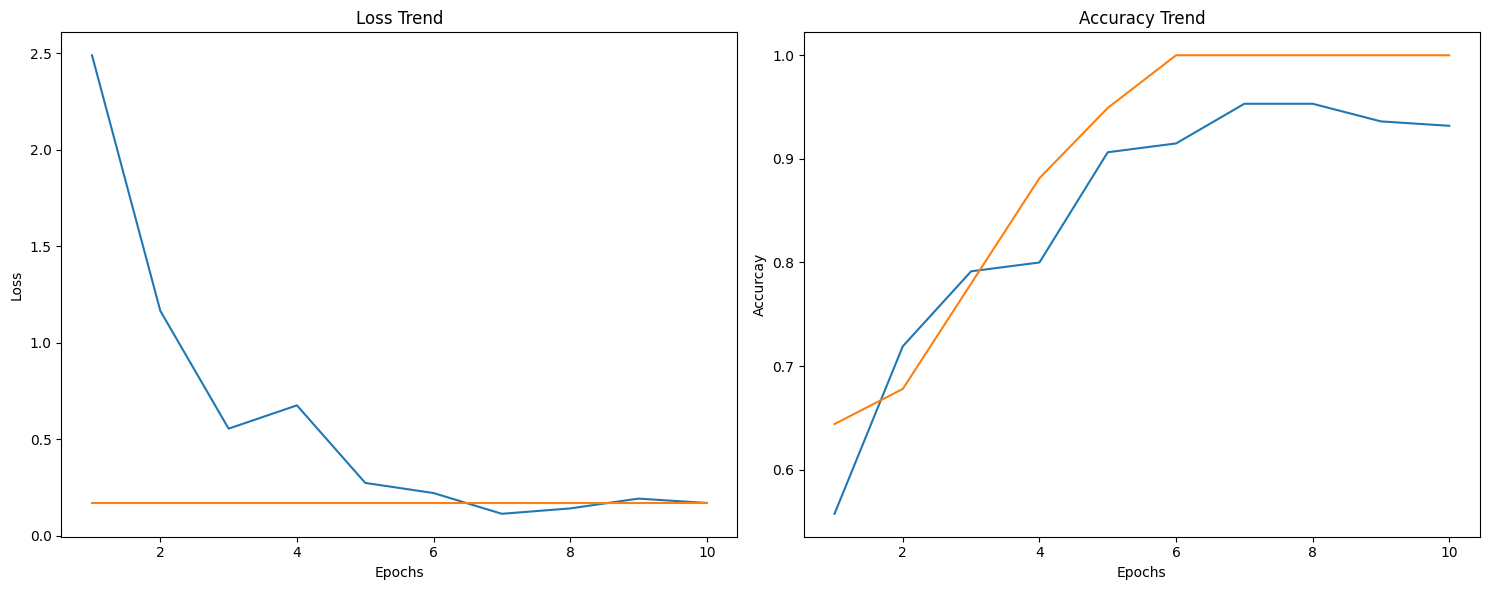

In [50]:
fig,axes=plt.subplots(1,2,figsize=(15,6))

axes[0].plot(range(1,epochs+1),train_loss,label="Train Loss")
axes[0].plot(range(1,epochs+1),eval_loss,label="Evaluation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Trend")

axes[1].plot(range(1,epochs+1),train_accuracy,label="Train Accuracy")
axes[1].plot(range(1,epochs+1),eval_accuracy,label="Evaluation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accurcay")
axes[1].set_title("Accuracy Trend")

plt.tight_layout()
plt.show()